In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly
import seaborn as sns
import os
import sqlite3

# Preprocessing
#from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer, make_column_selector, ColumnTransformer
from sklearn.ensemble import AdaBoostRegressor, VotingRegressor, GradientBoostingRegressor, StackingRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, cross_validate
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import RobustScaler, StandardScaler

# Model
from sklearn.dummy import DummyRegressor
from xgboost import XGBRegressor
import optuna
import shap
import joblib

from scripts.config import DATA_PATH, MODELS_PATH

%load_ext autoreload
%autoreload 2

%load_ext tensorboard

from tempfile import mkdtemp
# Create a temp folder
cachedir = mkdtemp()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 1. Import processed data

In [2]:
X_train_transformed = pd.read_csv(os.path.join(DATA_PATH, 'V1', 'X_train_transformed.csv'))
X_val_transformed = pd.read_csv(os.path.join(DATA_PATH, 'V1', 'X_val_transformed.csv'))
X_test_transformed = pd.read_csv(os.path.join(DATA_PATH, 'V1', 'X_test_transformed.csv'))
y_train = pd.read_csv(os.path.join(DATA_PATH, 'V1', 'y_train.csv'))
y_val = pd.read_csv(os.path.join(DATA_PATH, 'V1', 'y_val.csv'))
y_test = pd.read_csv(os.path.join(DATA_PATH, 'V1', 'y_test.csv'))

X_train = pd.read_csv(os.path.join(DATA_PATH, 'V1', 'X_train.csv'))
X_val = pd.read_csv(os.path.join(DATA_PATH, 'V1', 'X_val.csv'))
X_test = pd.read_csv(os.path.join(DATA_PATH, 'V1', 'X_test.csv'))

In [3]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34374 entries, 0 to 34373
Data columns (total 85 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   datetime          34374 non-null  object 
 1   FR_Solar          34374 non-null  float64
 2   FR_Wind Offshore  34374 non-null  float64
 3   FR_Wind Onshore   34374 non-null  float64
 4   FR_forecast_load  34374 non-null  float64
 5   EUA_EUR           34374 non-null  float64
 6   TTF_EUR           34374 non-null  float64
 7   ARA_EUR           34374 non-null  float64
 8   Day_sin           34374 non-null  float64
 9   Day_cos           34374 non-null  float64
 10  Year_sin          34374 non-null  float64
 11  Year_cos          34374 non-null  float64
 12  price_lag_24h     34374 non-null  float64
 13  price_lag_25h     34374 non-null  float64
 14  price_lag_26h     34374 non-null  float64
 15  price_lag_27h     34374 non-null  float64
 16  price_lag_28h     34374 non-null  float6

# 2. Forecast with MLP

In [4]:
from scripts.mlp_model import MLPModel

mlp = MLPModel(
    neurons=[64, 32, 16, 8],  # Two very small layers
    n_features=X_train_transformed.shape[1],
    outputShape=1,
    dropout=0.3,
    batch_normalization=True,
    learning_rate=0.0005,
    verbose=True,
    epochs_early_stopping=15,
    loss='mse',
    metrics=['mae'],
    activation='relu',
    regularization='l2',
    lambda_reg=0.05
)

mlp

2025-08-16 13:47:49.341614: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-16 13:47:49.356214: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-16 13:47:49.466323: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-16 13:47:49.557715: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755344869.636622    5709 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755344869.65

Epoch 1/1000
1075/1075 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 1888.2104 - mae: 39.4967 - val_loss: 2634.1340 - val_mae: 45.7856
Epoch 2/1000
1075/1075 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 1225.7230 - mae: 32.1591 - val_loss: 1046.6652 - val_mae: 29.3356
Epoch 3/1000
1075/1075 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 659.2183 - mae: 21.0674 - val_loss: 424.4881 - val_mae: 17.1356
Epoch 4/1000
1075/1075 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 283.8967 - mae: 12.3947 - val_loss: 332.5979 - val_mae: 13.1456
Epoch 5/1000
1075/1075 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 234.9226 - mae: 10.1052 - val_loss: 257.7296 - val_mae: 10.9158
Epoch 6/1000
1075/1075 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 201.9157 - mae: 9.8303 - val_loss: 282.7329 - val_mae: 11.6801
Epoch 7/1000
1075/1075 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 263.3541 - mae: 9.7588 - val_loss: 284.8075 - val_mae: 11.5122
Epoch 8/1000
1075/1075 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 291.5755 - mae: 9.7283 - val_loss: 305

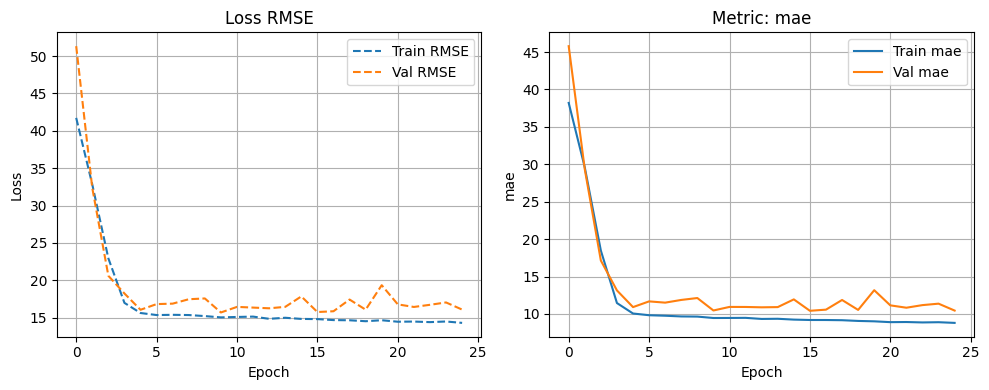

310/310 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 104.4525 - mae: 6.3396
1075/1075 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 105.8448 - mae: 5.1672

Final Training Metrics:
RMSE: 10.5284
['mae']: [5.301108360290527]

Final Validation Metrics:
RMSE: 15.6954
['mae']: [10.463689804077148]


In [5]:
mlp.fit(X_train_transformed, y_train, X_val_transformed, y_val)


In [ ]:
from scripts.config import LOGS_PATH
%tensorboard --logdir {LOGS_PATH}/MLP/fit

Launching TensorBoard...